In [ ]:
!pip install pycaret
!pip install streamlit -q

![image.png](attachment:image.png)

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [ ]:
# importando as biliotecas para a tarefa 1

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, interactive

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importando os dados

df = pd.read_feather('/content/drive/MyDrive/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [ ]:
# Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.

df['data_ref'].value_counts()

,count
data_ref,
2015-01-01,50000
2015-02-01,50000
2015-03-01,50000
2015-04-01,50000
2015-05-01,50000
2015-06-01,50000
2015-07-01,50000
2015-08-01,50000
2015-09-01,50000


In [ ]:
# separando as variáveis númericas e categóricas para posterior análise dos dados

variaveis_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']
variaveis_numericas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

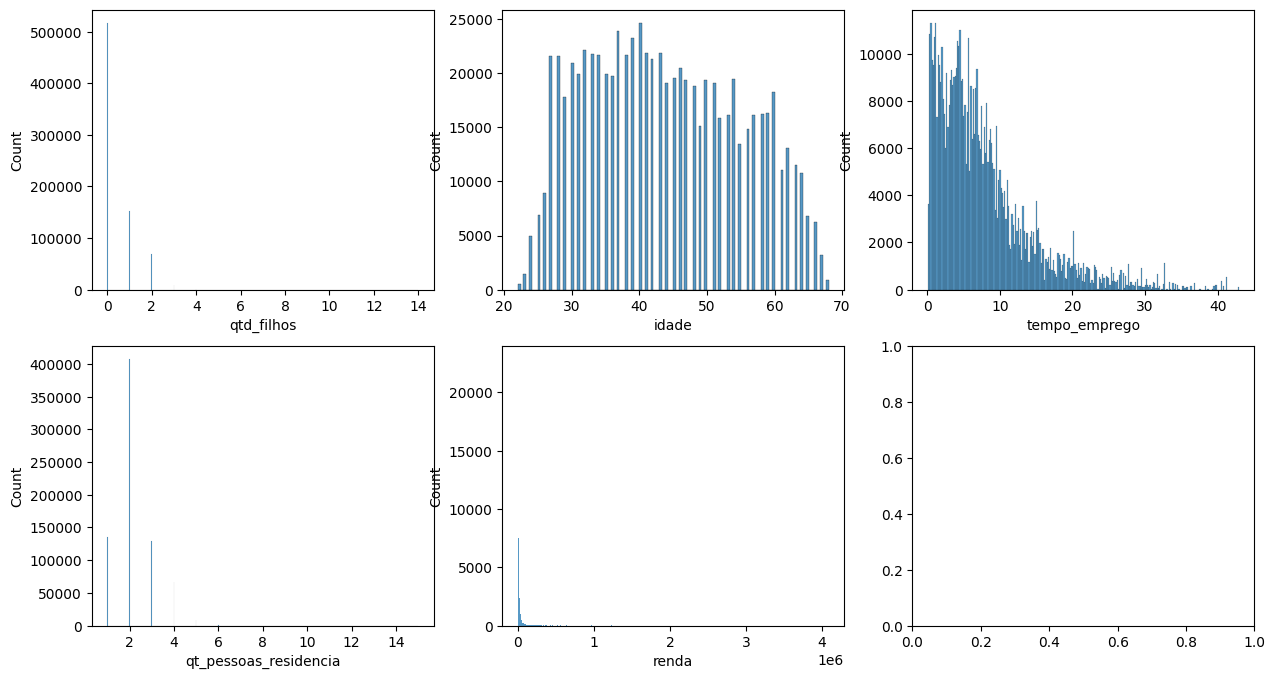

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

i = 0
j = 0

for col in variaveis_numericas:

  sns.histplot(df[col], ax=ax[i, j])

  if j < 2:
    j += 1
  else:
    i += 1
    j = 0

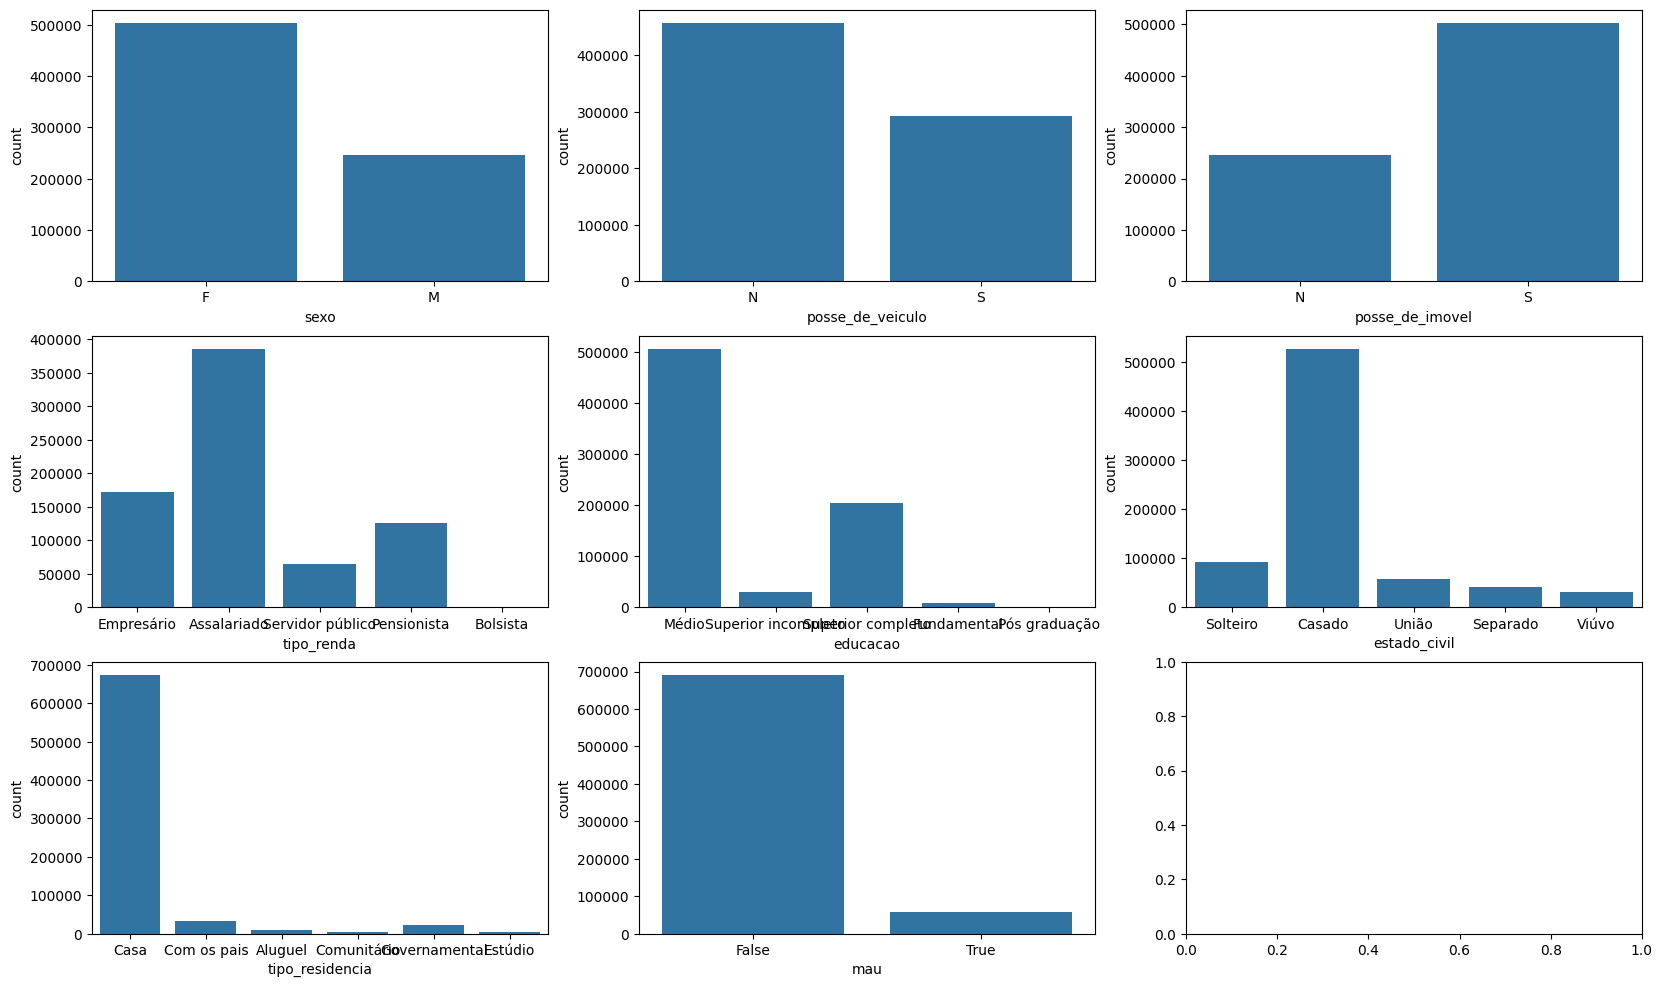

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))

i = 0
j = 0

for col in variaveis_categoricas:

  sns.countplot(x=df[col],ax=ax[i, j])

  if j < 2:
    j += 1
  else:
    i += 1
    j = 0

In [ ]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [ ]:
# construindo a base de metadados

metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['missing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'

# calculando o IV de cada variável

for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)


metadados

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [ ]:
# análise bivariada das variáveis categóricas


def biv_discreta(var, base):
    df = base.copy()
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        'cont':g[var].count()})

    biv[var] = g['mau'].mean().index

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)

    ax[1] = biv.cont.plot.bar()

    plt.show()

In [ ]:
%matplotlib inline

@interact(var=variaveis_categoricas)
def biv_discreta_inter(var):
  biv_discreta(var, df)

*Após análise, a fim de otimidar o desempenho do modelo a ser elaborado, será interessante:*

*   Integrar bolsista ao assalariado
*   categorizar escolaridade por até o médio e pós médio
*   integrar estado civil separado, solteiro, união, e viúvo
*   catgorizar tipo de residência por casa e não casa

In [ ]:
# análise bivariada das variáveis numéricas

def biv_continua(var, ncat, base):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g[var].mean(),
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))

    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    plt.show()

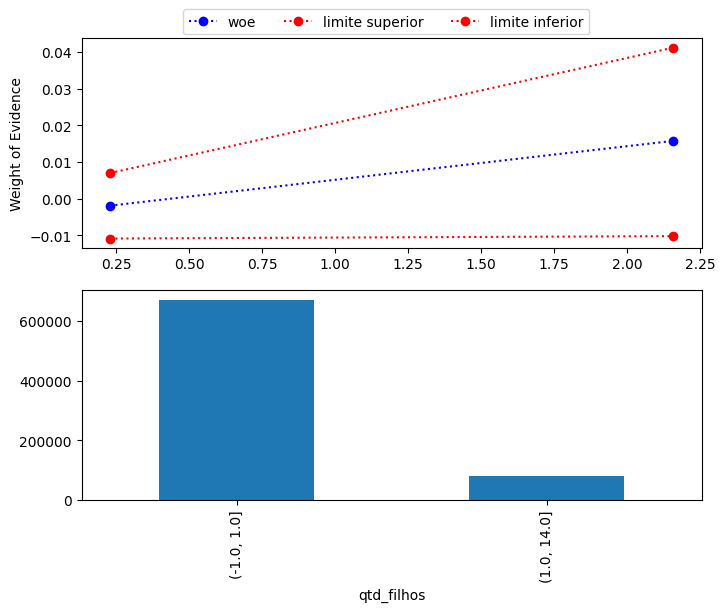

In [ ]:
%matplotlib inline

@interact(var=variaveis_numericas, ncat=(2,10))
def biv_continua_inter(var, ncat):
  biv_continua(var, ncat, df)

*Após análise, a fim de otimidar o desempenho do modelo a ser elaborado, será interessante:*

*   integrar com ou sem filhos
*   dividir idade em duas categorias
*   dividir tempo de emprego em duas categorias
*   dividir quantidade de pessoas na residencia em duas categorias
*   dividir renda em 4 categorias

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [ ]:
df2 = df.copy()

In [ ]:
# agrupamento de categorias

# Integrar bolsista ao assalariado
df2.tipo_renda.replace({'Bolsista':'Assalariado'}, inplace=True)

# caegorizar até o médio e pós médio
df2.educacao.replace({
    'Médio':'Ate_medio',
    'Fundamental': 'Ate_medio',
    'Superior completo': 'Superior',
    'Superior incompleto': 'Superior',
    'Pós graduação': 'Superior',
     }, inplace=True)

# integrar separado, solteiro, união, e viúvo
df2.estado_civil.replace({
    'Solteiro':'Nao_casado',
    'União': 'Nao_casado',
    'Separado': 'Nao_casado',
    'Viúvo': 'Nao_casado',
     }, inplace=True)

# separar em tipos de residência em casa ou não
df2.tipo_residencia.replace({
    'Com os pais':'Nao_casa',
    'Aluguel': 'Nao_casa',
    'Comunitário': 'Nao_casa',
    'Governamental': 'Nao_casa',
    'Estúdio': 'Nao_casa',
     }, inplace=True)


In [ ]:
# agrupameno variáveis categóricas

# agrupar tem ou não filhos
df2['tem_filhos'] = df2.qtd_filhos.apply(lambda x: 1 if x > 0 else 0)

# agrupar tem 2 pessoa na residência ou mais
df2['qt_pessoas_residencia_cat'] = df2.qt_pessoas_residencia.apply(lambda x: 'ate_2' if x >= 2 else 'mais_2')

# dividir idade em duas categorias
df2['idade_cat'] = pd.qcut(df['idade'], 2)

# dividir tempo de emprego em duas categorias
df2['tempo_emprego_cat'] = pd.qcut(df['tempo_emprego'], 2)

# dividir renda em 4 categorias
df2['renda_cat'] = pd.qcut(df['renda'], 4)

In [ ]:
# Transformar a variável resposta em inteiro
df2['mau'] = df2.mau.astype('int64')

In [ ]:
# Separe os três últimos meses como safras de validação *out of time* (oot).

df_treino = df2.loc[df['data_ref'].isin(df2['data_ref'].unique()[:-3])]
df_teste = df2.loc[~df['data_ref'].isin(df2['data_ref'].unique()[:-3])]

In [ ]:
# excluindo linhas com missings

df_treino = df_treino.drop(df_treino.loc[df2['tempo_emprego'].isna()].index)
df_teste = df_teste.drop(df_teste.loc[df2['tempo_emprego'].isna()].index)

In [ ]:
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + tem_filhos + tipo_renda +
    educacao + estado_civil + tipo_residencia + idade_cat + tempo_emprego_cat +
    renda_cat + qt_pessoas_residencia_cat
    '''

rl = smf.glm(formula, data=df_treino, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               499125
Model:                            GLM   Df Residuals:                   499108
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0055e+05
Date:                Wed, 02 Oct 2024   Deviance:                   2.0109e+05
Time:                        14:35:23   Pearson chi2:                 4.99e+05
No. Iterations:                     8   Pseudo R-squ. (CS):            0.05204
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       -1.4322      0.018    -80.768      0.000      -1.467      -1.397
sexo[T.M]                                                       -0.0643      0.014     -4.625      0.000      -0.092      -0.037
posse_de_veiculo[T.S]                                            0.0277      0.013      2.064      0.039       0.001       0.054
posse_de_imovel[T.S]                                            -0.0655      0.013     -5.058      0.000      -0.091      -0.040
tipo_renda[T.Empresário]                                        -0.0239      0.014     -1.690      0.091      -0.052       0.004
tipo_renda[T.Pensionista]                                       -0.0196      0.230     -0.085      0.932      -0.470       0.431
tipo_renda[T.Servidor público]                                  -0.0295      0.023     -1.261      0.207      -0.075       0.016
educacao[T.Superior]                                            -0.0412      0.014     -3.041      0.002      -0.068      -0.015
estado_civil[T.Nao_casado]                                       0.0321      0.018      1.735      0.083      -0.004       0.068
tipo_residencia[T.Nao_casa]                                      0.0191      0.019      1.016      0.310      -0.018       0.056
idade_cat[T.Interval(43.0, 68.0, closed='right')]               -0.0149      0.014     -1.041      0.298      -0.043       0.013
tempo_emprego_cat[T.Interval(6.047, 42.907, closed='right')]    -0.1469      0.015    -10.024      0.000      -0.176      -0.118
renda_cat[T.Interval(3467.7, 7861.82, closed='right')]          -1.0156      0.015    -69.351      0.000      -1.044      -0.987
renda_cat[T.Interval(7861.82, 18318.28, closed='right')]        -1.7398      0.018    -96.763      0.000      -1.775      -1.705
renda_cat[T.Interval(18318.28, 4083986.22, closed='right')]     -2.8818      0.028   -104.182      0.000      -2.936      -2.828
qt_pessoas_residencia_cat[T.mais_2]                             -0.0471      0.024     -1.957      0.050      -0.094    7.19e-05
tem_filhos                                                      -0.0023      0.014     -0.160      0.873      -0.030       0.026
================================================================================================================================
"""

*Verifica-se que as variáveis mais significantes são: sexo, posse de imóvel, educacao, tempo de emprego categórico, renda categórica*

In [ ]:
formula = '''
    mau ~ sexo + posse_de_imovel +
    educacao + tempo_emprego_cat +
    renda_cat
    '''

rl = smf.glm(formula, data=df_treino, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               499125
Model:                            GLM   Df Residuals:                   499117
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0055e+05
Date:                Wed, 02 Oct 2024   Deviance:                   2.0111e+05
Time:                        14:35:32   Pearson chi2:                 4.99e+05
No. Iterations:                     8   Pseudo R-squ. (CS):            0.05201
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       -1.4320      0.013   -107.800      0.000      -1.458      -1.406
sexo[T.M]                                                       -0.0524      0.013     -4.042      0.000      -0.078      -0.027
posse_de_imovel[T.S]                                            -0.0693      0.013     -5.501      0.000      -0.094      -0.045
educacao[T.Superior]                                            -0.0396      0.013     -3.011      0.003      -0.065      -0.014
tempo_emprego_cat[T.Interval(6.047, 42.907, closed='right')]    -0.1478      0.015    -10.171      0.000      -0.176      -0.119
renda_cat[T.Interval(3467.7, 7861.82, closed='right')]          -1.0167      0.015    -69.487      0.000      -1.045      -0.988
renda_cat[T.Interval(7861.82, 18318.28, closed='right')]        -1.7419      0.018    -97.038      0.000      -1.777      -1.707
renda_cat[T.Interval(18318.28, 4083986.22, closed='right')]     -2.8870      0.028   -104.828      0.000      -2.941      -2.833
================================================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [ ]:
proporcao_mau = df2.mau.value_counts()[1] / df2.mau.value_counts().sum()

In [ ]:
df_treino['score'] = rl.predict()

# Acurácia
acc = metrics.accuracy_score(df_treino.mau, df_treino.score > proporcao_mau)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_treino.mau, df_treino.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_treino.loc[df_treino.mau == 1, 'score'], df_treino.loc[df_treino.mau != 1, 'score']).statistic

print('RESULTADOS NA BASE DE TREINO')
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

In [ ]:
df_teste['score'] = rl.predict(df_teste)

# Acurácia
acc = metrics.accuracy_score(df_teste.mau, df_teste.score > proporcao_mau)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_teste.mau, df_teste.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_teste.loc[df_teste.mau == 1, 'score'], df_teste.loc[df_teste.mau != 1, 'score']).statistic

print('RESULTADOS NA BASE DE TESTE')
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

RESULTADOS NA BASE DE TESTE
Acurácia: 54.4% 
AUC: 70.4% 
GINI: 40.9%
KS: 33.6%


## Criar um pipeline utilizando o sklearn pipeline

In [ ]:
# importando biliotecas para a tarefa 2

import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

## Pré processamento

In [ ]:
# importando os dados

df = pd.read_feather('/content/drive/MyDrive/credit_scoring.ftr')
df.head(5)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [ ]:
# removendo dados duplicados

df = df.drop_duplicates()

In [ ]:
# Separe os três últimos meses como safras de validação *out of time* (oot).

df_treino = df.loc[df['data_ref'].isin(df['data_ref'].unique()[:-3])]
df_teste = df.loc[~df['data_ref'].isin(df['data_ref'].unique()[:-3])]

In [ ]:
# separando features explicativos e target

x_treino = df_treino.drop('mau', axis=1)
x_teste = df_teste.drop('mau', axis=1)
y_treino = df_treino.mau
y_teste = df_teste.mau

### Remover colunas

In [ ]:
def remove_columns(X):

  X = X.drop(['data_ref', 'index'], axis=1)

  return X


In [ ]:
# criando step de remoção de outliers para aplicação em pipeline

ct_remove_columns = FunctionTransformer(remove_columns)

In [ ]:
x_treino = ct_remove_columns.fit_transform(x_treino)

x_teste = ct_remove_columns.transform(x_teste)

### Remoção de outliers


Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [ ]:
# criando função para remoção de outliers

def remove_outliers(X):

  # Calcular os quartis Q1 e Q3
  Q1 = X.quantile(0.25)
  Q3 = X.quantile(0.75)

  # Calcular o IQR
  IQR = Q3 - Q1

  # Definir os limites inferior e superior
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR

  # Remover outliers
  X_new = X[(X >= limite_inferior) & (X <= limite_superior)]

  return X_new

In [ ]:
# criando step de remoção de outliers para aplicação em pipeline

ct_remove_outlier = ColumnTransformer([
      ('out', FunctionTransformer(remove_outliers),
      make_column_selector(dtype_include=np.number))], remainder='passthrough')

In [ ]:
# aplicando a transformação

x_treino = ct_remove_outlier.fit_transform(x_treino)

x_teste = ct_remove_outlier.transform(x_teste)

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [ ]:
# criando step para imputação de valores

ct_missing = ColumnTransformer([
      ('median', SimpleImputer(strategy='median'), # mediana em missings numéricos
      [0,1,2,3,4]),
      ('most_frequent', SimpleImputer(strategy='most_frequent'), # moda em missings categóricos
      [5,6,7,8,9,10,11])])

In [ ]:
# aplicando a transformação

x_treino = ct_missing.fit_transform(x_treino)

x_teste = ct_missing.transform(x_teste)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [ ]:
# criando step para aplicação de PCA sobre os dados

ct_pca = ColumnTransformer([
      ('pca', PCA(n_components=5),
      [0,1,2,3,4])], remainder='passthrough')

In [ ]:
# aplicando a transformação

x_treino = ct_pca.fit_transform(x_treino)

x_teste = ct_pca.transform(x_teste)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [ ]:
# criando step para criação de dummies de variáveis categóricas

ct_dummie = ColumnTransformer([
      ('onehot', OneHotEncoder(),
      [5,6,7,8,9,10,11])], remainder='passthrough')

In [ ]:
# aplicando a transformação

x_treino = ct_dummie.fit_transform(x_treino)

x_teste = ct_dummie.transform(x_teste)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

In [ ]:
# selecionado as features através da técnica LinearSVC

lsvc = LinearSVC(penalty="l1", dual=False).fit(x_treino, y_treino)

model = SelectFromModel(lsvc, prefit=True)

In [ ]:
# aplicando a transformação

x_treino = model.transform(x_treino)

x_teste = model.transform(x_teste)

### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [ ]:
# importando os dados

df = pd.read_feather('/content/drive/MyDrive/credit_scoring.ftr')

# removendo dados duplicados

df = df.drop_duplicates()

# separando dados para treino e teste

df_treino = df.loc[df['data_ref'].isin(df['data_ref'].unique()[:-3])]
df_teste = df.loc[~df['data_ref'].isin(df['data_ref'].unique()[:-3])]

# separando features explicativos e target

x_treino = df_treino.drop('mau', axis=1)
x_teste = df_teste.drop('mau', axis=1)
y_treino = df_treino.mau
y_teste = df_teste.mau

In [ ]:
# criando pipeline através de sklearn com as etapas criadas anteriormente

preprocessamento = Pipeline(steps=[
                          ("remove_columns", ct_remove_columns),
                          ("outliers", ct_remove_outlier),
                          ("missing", ct_missing),
                          ("pca", ct_pca),
                          ("dummies", ct_dummie)])

### Treinar um modelo de regressão logistica com o resultado

In [ ]:
# processando os dados através do pipeline

x_treino_p = preprocessamento.fit_transform(x_treino)

x_teste_p = preprocessamento.transform(x_teste)

In [ ]:
# treinando o modelo preditivo

clf = tree.DecisionTreeClassifier().fit(x_treino_p, y_treino)

### Avaliando a performance do modelo

In [ ]:
# salvando as predições do modelo na base de treino e de teste

pred_treino = clf.predict(x_treino_p)

pred_teste = clf.predict(x_teste_p)

Acurácia na base de treino: 0.8644403125200363


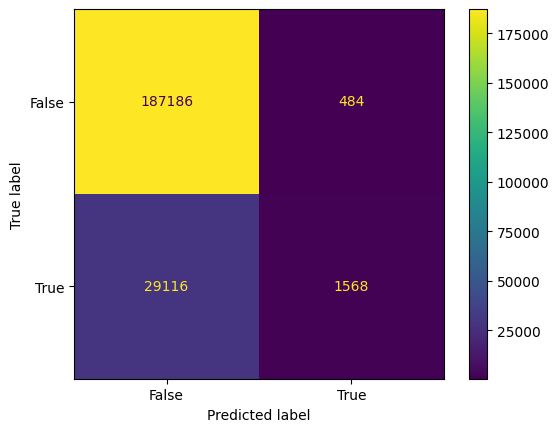

In [ ]:
# verificando a acurácia do modelo na base de treino

cm = confusion_matrix(y_treino, pred_treino)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()

print(f'Acurácia na base de treino: {accuracy_score(y_treino, pred_treino)}')

Acurácia na base de teste: 0.7284826974267968


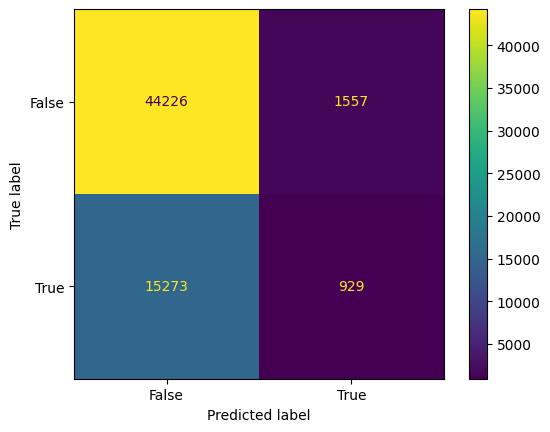

In [ ]:
# verificando a acurácia do modelo na base de teste

cm = confusion_matrix(y_teste, pred_teste)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()

print(f'Acurácia na base de teste: {accuracy_score(y_teste, pred_teste)}')

Apesar de o modelo apresentar performance com alta acurácia, não se mostra sensível na detecção de 'maus' clientes. Isso se deve, provavelmente, à pouca representação de ocorrência de 'mau' na amostra. Será interessante verificar qual o melhor ajuste para se obter maior deteção de 'maus' - Recall -, com menor geração falsos positivos - Precisão.

Probabilidade de 'mau' em que F1 - score atinge maior valor nas bases de dados: 0.3061224489795918


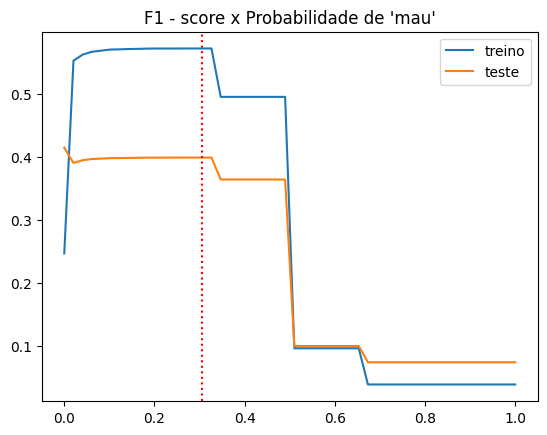

In [ ]:
# verificando o F1 - score conforme taxa de probabilidade de 'mau' atribuída pelo modelo

prob_mau = clf.predict_proba(x_treino_p)[:,1]
prob_mau_t = clf.predict_proba(x_teste_p)[:,1]

x = np.linspace(0,1)

y_tr = [f1_score(y_treino,(prob_mau >= i)) for i in x]
y_te = [f1_score(y_teste,(prob_mau_t >= i)) for i in x]

plt.plot(x, y_tr, label='treino')
plt.plot(x, y_te, label='teste')
plt.axvline(x=x[15], color='r', linestyle='dotted')
plt.title("F1 - score x Probabilidade de 'mau'")
plt.legend()

print(f"Probabilidade de 'mau' em que F1 - score atinge maior valor nas bases de dados: {x[15]}")


Acurácia na base de treino, classificando 'mau' a partir de 20% de probabilidade': 0.7919204594374273


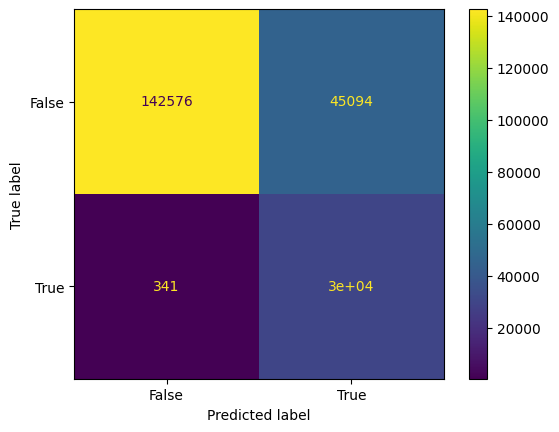

In [ ]:
# verificando a acurácia do modelo na base de treino ao trabalhar a probabilidade de 'mau' com 30%

cm = confusion_matrix(y_treino, (prob_mau >= 0.30))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()

print(f"Acurácia na base de treino, classificando 'mau' a partir de 20% de probabilidade': {accuracy_score(y_treino, (prob_mau >= 0.30))}")

Acurácia na base de teste, classificando 'mau' a partir de 20% de probabilidade': 0.5865773977575219


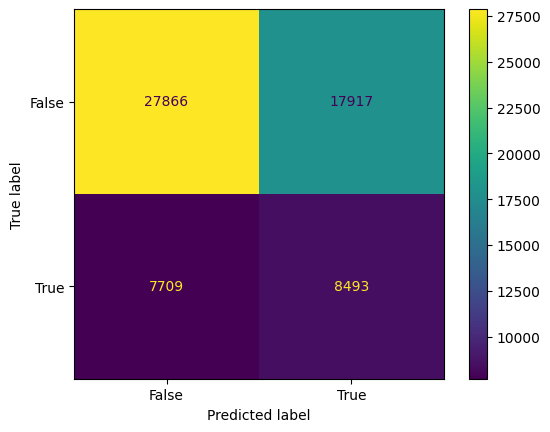

In [ ]:
# verificando a acurácia do modelo na base de teste ao trabalhar a probabilidade de 'mau' com 20%

cm = confusion_matrix(y_teste, (prob_mau_t >= 0.30))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()

print(f"Acurácia na base de teste, classificando 'mau' a partir de 20% de probabilidade': {accuracy_score(y_teste, (prob_mau_t >= 0.30))}")

Em face dos resultados, constata-se que a busca por melhor permance do modelo sob a métrica de F1 score ocorre em detrimento da acurária. O contrário também acontece. Daí, a fim de se aproveitar os resultados de ambas abordagens, podemos adotar a seguinte classificação de risco de crédito (inadimplência) de acordo a probabilidade de 'mau' atribuída pelo modelo:

*   RISCO ALTO: probabilidade de 'mau' maior que 50%
*   RISCO MÉDIO: probabilidade de 'mau' de 30% a 50%
*   RISCO BAIXO: probabilidade de 'mau' menor que 20%

A vantagem também é que se dá maior margem de decisão, principalmente sobre os classificados de RISCO MÉDIO




### Salvar o pickle file do modelo treinado

In [ ]:
# gravando o modelo

import pickle

nome_arquivo = '/content/drive/MyDrive/PROJ_EBAC_FINAL/modelo/model_final.pkl'
pickle.dump(clf, open(nome_arquivo, 'wb'))

In [ ]:
# gravando o pipeline

from joblib import dump

dump(preprocessamento, '/content/drive/MyDrive/PROJ_EBAC_FINAL/modelo/pipe.joblib')

['/content/drive/MyDrive/PROJ_EBAC_FINAL/modelo/pipe.joblib']

# Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [ ]:
from pycaret.classification import *
from sklearn import set_config

In [ ]:
df = pd.read_feather('/content/drive/MyDrive/credit_scoring.ftr')
df.head(5)

In [ ]:
data = df.drop(['data_ref', 'index'], axis=1)

In [ ]:
clf = setup(data = data,
            target = 'mau',
            encoding_method='category-encoders estimator',
            numeric_imputation='median',
            remove_outliers=True,
            remove_multicollinearity = True,
            session_id=123)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 13)"
4,Transformed data shape,"(723761, 30)"
5,Transformed train set shape,"(498761, 30)"
6,Transformed test set shape,"(225000, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.8%


In [ ]:
lightgbm = create_model('lightgbm')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:37:11
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9220,0.7714,0.0244,0.5263,0.0466,0.0399,0.1006
1,0.9220,0.7871,0.0251,0.5228,0.0479,0.0410,0.1016
2,0.9226,0.7787,0.0283,0.6073,0.0540,0.0474,0.1191
3,0.9222,0.7819,0.0244,0.5495,0.0467,0.0403,0.1035
4,0.9219,0.7840,0.0222,0.5170,0.0425,0.0363,0.0948
5,0.9225,0.7768,0.0261,0.6011,0.0500,0.0438,0.1136
6,0.9224,0.7830,0.0258,0.5856,0.0495,0.0431,0.1112
7,0.9219,0.7791,0.0246,0.5101,0.0469,0.0400,0.0990
8,0.9218,0.7788,0.0207,0.5030,0.0398,0.0338,0.0899


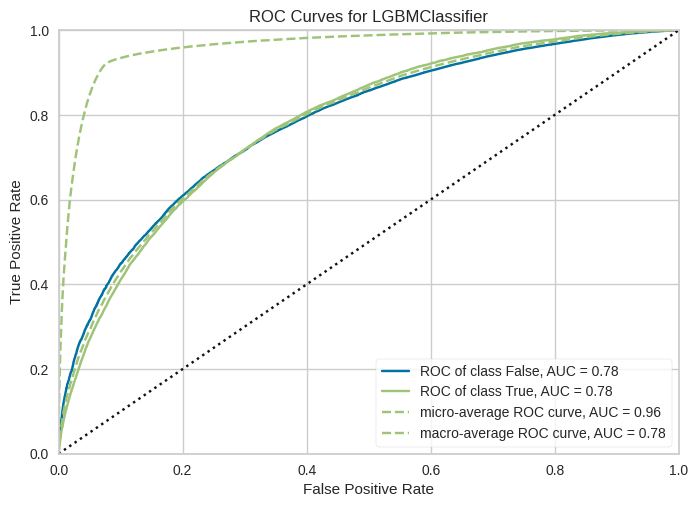

In [ ]:
plot_model(lightgbm)

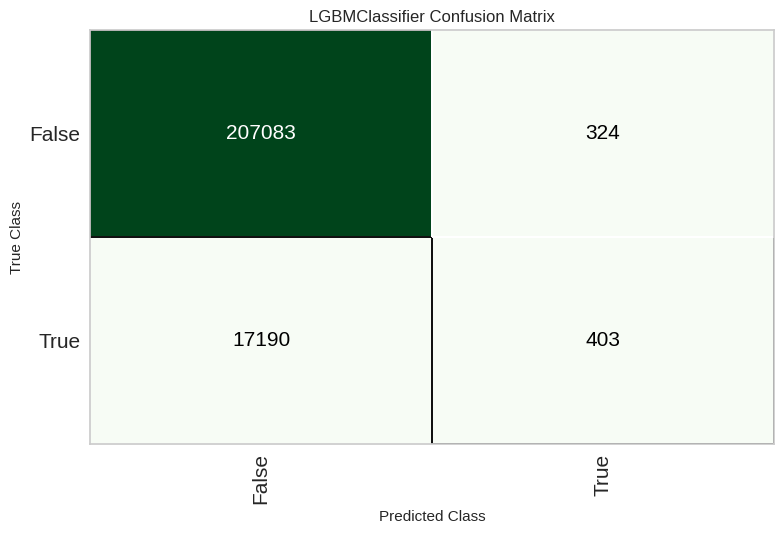

In [ ]:
plot_model(lightgbm, plot = 'confusion_matrix')

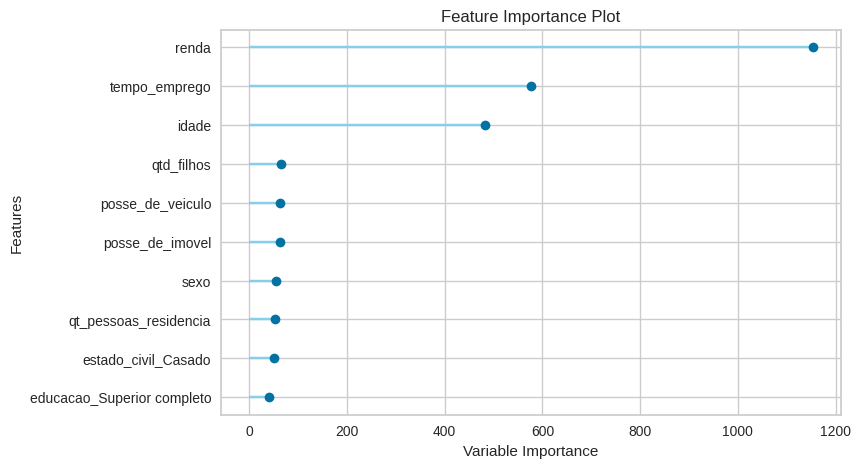

In [ ]:
plot_model(lightgbm, plot = 'feature')

### Salvar o arquivo do modelo treinado

In [ ]:
save_model(lightgbm, model_name='lightgbm-model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='median'))),
                 ('categorical_imputer',
                  TransformerW...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
            

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit
    - Subir um csv no streamlit
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos.
1. Enviar links do github para o tutor corrigir.